#### Import packages

In [1]:
import pandas as pd
import wikipedia as wp
import numpy as np
import matplotlib.pyplot as plt
import pgeocode # import pgeocode
import folium # map rendering library
import requests
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

#### Read Wikipedia table

In [2]:
html = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")
try: 
    df_postal_code = pd.read_html(html)[0]  # Try 2nd table first as most pages contain contents table first
except IndexError:
    df_postal_code = pd.read_html(html)[1]


In [3]:
# Check Borough values
df_postal_code['Borough'].value_counts()

Not assigned        77
North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
York                 5
East Toronto         5
East York            5
Mississauga          1
Name: Borough, dtype: int64

In [4]:
# Remove Not Assigned borough
df_postal_code = df_postal_code.drop(df_postal_code[df_postal_code['Borough'] == 'Not assigned'].index)
df_postal_code.reset_index(drop = True, inplace = True)

In [5]:
# Shape of dataset
print(df_postal_code.shape)
df_postal_code

(103, 3)


,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


#### Add latitude and longitude

In [6]:
geocode = pgeocode.Nominatim('ca')

df_postal_code['latitude'] = ''
df_postal_code['longitude'] = ''

for index,code in enumerate(df_postal_code['Postal Code']):
    df_postal_code.loc[index,'latitude'] = geocode.query_postal_code(code)['latitude']
    df_postal_code.loc[index,'longitude'] = geocode.query_postal_code(code)['longitude']

In [7]:
# Drop postal codes with no longitude and latitude detected 

df_postal_code=df_postal_code.dropna(subset=['latitude'])
df_postal_code=df_postal_code.dropna(subset=['longitude'])

In [8]:
df_postal_code

,Postal Code,Borough,Neighborhood,latitude,longitude
0,M3A,North York,Parkwoods,43.7545,-79.33
1,M4A,North York,Victoria Village,43.7276,-79.3148
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.6518,-79.5076
99,M4Y,Downtown Toronto,Church and Wellesley,43.6656,-79.383
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.7804,-79.2505
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.6325,-79.4939


In [9]:
# Create Toronto Map

toronto_latitude = 43.6532
toronto_longitude = -79.3832

map_toronto = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=10)
map_toronto

In [10]:
# Add markers to map

for lat, lng, borough, neighborhood in zip(df_postal_code['latitude'], df_postal_code['longitude'], df_postal_code['Borough'], df_postal_code['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto) 

In [11]:
map_toronto

#### Connecting to Foursquare

In [12]:
CLIENT_ID = 'YXTKAWRUBA1SNMTSJ01ETW2Z2OADLUIRNVMV1TX0UAZO0IC5' # your Foursquare ID
CLIENT_SECRET = 'CS03U4LZDQA1P2BPERQHLQRARG34TDUCX5SAKRKIAL5TTWZI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YXTKAWRUBA1SNMTSJ01ETW2Z2OADLUIRNVMV1TX0UAZO0IC5
CLIENT_SECRET:CS03U4LZDQA1P2BPERQHLQRARG34TDUCX5SAKRKIAL5TTWZI


In [13]:
# Function to analyze neighborhoods

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
LIMIT = 100
radius = 500

toronto_venues = getNearbyVenues(names=df_postal_code['Neighborhood'],
                                   latitudes=df_postal_code['latitude'],
                                   longitudes=df_postal_code['longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [15]:
#Check toronto_venues dataframe

toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.7545,-79.3300,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.7545,-79.3300,GTA Restoration,43.753396,-79.333477,Fireworks Store
2,Parkwoods,43.7545,-79.3300,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.7276,-79.3148,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.7276,-79.3148,Tim Hortons,43.725517,-79.313103,Coffee Shop


#### Analyze neighborhoods

In [16]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Group by Neighborhood
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [18]:
toronto_grouped.shape

(97, 261)

In [19]:
# Common venues for neighborhoods

num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0               Skating Rink  0.25
1  Latin American Restaurant  0.25
2            Badminton Court  0.25
3             Breakfast Spot  0.25
4          Mobile Phone Shop  0.00


----Alderwood, Long Branch----
               venue  freq
0        Pizza Place  0.11
1     Sandwich Place  0.11
2       Dance Studio  0.11
3           Pharmacy  0.11
4  Convenience Store  0.11


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0                Pizza Place  0.12
1                Coffee Shop  0.12
2   Mediterranean Restaurant  0.12
3        Fried Chicken Joint  0.12
4  Middle Eastern Restaurant  0.12


----Bayview Village----
                venue  freq
0               Trail  0.33
1                Park  0.33
2         Gas Station  0.33
3         Yoga Studio  0.00
4  Miscellaneous Shop  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0      Sandwich Place  0.08
1         Coffe

In [20]:
# Create function for common venues

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
# Create dataframe for common venues

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

pd.set_option('display.max_rows', None)    
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Badminton Court,Breakfast Spot,Skating Rink,Latin American Restaurant,Women's Store,Farmers Market,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant
1,"Alderwood, Long Branch",Athletics & Sports,Pharmacy,Convenience Store,Pizza Place,Sandwich Place,Coffee Shop,Dance Studio,Pub,Gym,Ethiopian Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Spa,Pizza Place,Mediterranean Restaurant,Middle Eastern Restaurant,Deli / Bodega,Coffee Shop,Fried Chicken Joint,Grocery Store,Event Space,Eastern European Restaurant
3,Bayview Village,Park,Gas Station,Trail,Women's Store,Event Space,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Restaurant,Sandwich Place,Italian Restaurant,Comfort Food Restaurant,Thai Restaurant,Pharmacy,Pizza Place,Pub,Café


### Clustering Neighborhoods

In [22]:
# Drop Neighborhood column

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

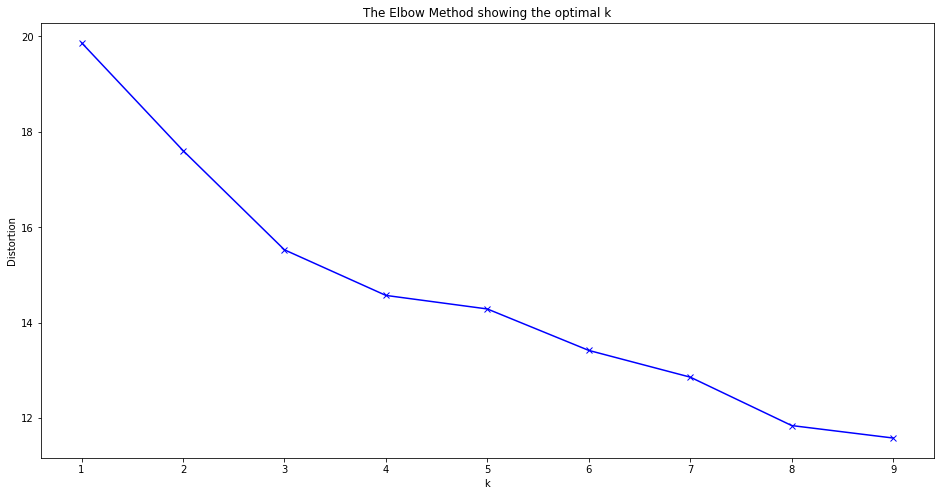

In [23]:
# Find number of clusters using Elbow method

distortions = []
list_clusters = range(1,10)
for clusters in list_clusters:
    kmeans = KMeans(n_clusters = clusters)
    kmeans.fit(toronto_grouped_clustering)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(16,8))
plt.plot(list_clusters, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [24]:
# Selecting 3 clusters
kclusters = 3
kmeans = KMeans(n_clusters = kclusters)
kmeans.fit(toronto_grouped_clustering)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [25]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_postal_code

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged['Cluster Labels'].value_counts() # check the last columns!

0.0    80
2.0    18
1.0     3
Name: Cluster Labels, dtype: int64

In [26]:
# Some neighborhours couldnt be clustered because they were not find it at the beggining, so in the merge, some NaN appeared

toronto_merged = toronto_merged.dropna(subset=['Cluster Labels'])

In [27]:
#Create cluster map

map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['latitude'], toronto_merged['longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters